In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/productivity-prediction-of-garment-employees/garments_worker_productivity.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


from sklearn.metrics import accuracy_score, confusion_matrix,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder,PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Attribute Information:
1. date : Date in MM-DD-YYYY
2. day : Day of the Week
3. quarter : A portion of the month. A month was divided into four quarters
4. department : Associated department with the instance
5. teamno : Associated team number with the instance
6. noofworkers : Number of workers in each team 
7. noofstylechange : Number of changes in the style of a particular product
8. targetedproductivity : Targeted productivity set by the Authority for each team for each day.
9. smv : Standard Minute Value, it is the allocated time for a task 
10. wip : Work in progress. Includes the number of unfinished items for products 
11. overtime : Represents the amount of overtime by each team in minutes
12. incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
13. idletime : The amount of time when the production was interrupted due to several reasons 
14. idlemen : The number of workers who were idle due to production interruption
15. actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.

In [3]:
df = pd.read_csv('../input/productivity-prediction-of-garment-employees/garments_worker_productivity.csv')

In [4]:
df.sample(10)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
865,2/22/2015,Quarter4,finishing,Sunday,6,0.80,2.90,NaN,960,0,0.0,0,0,8.0,0.831937
351,1/20/2015,Quarter3,finishing,Tuesday,11,0.70,4.15,NaN,2700,0,0.0,0,0,15.0,0.362667
300,1/18/2015,Quarter3,finishing,Sunday,11,0.65,4.15,NaN,2160,0,0.0,0,0,12.0,0.838384
853,2/19/2015,Quarter3,sweing,Thursday,3,0.70,30.10,247.0,6960,50,0.0,0,1,58.0,0.700603
1032,3/3/2015,Quarter1,sweing,Tuesday,4,0.70,26.66,950.0,6960,50,0.0,0,0,58.0,0.750770
801,2/16/2015,Quarter3,sweing,Monday,9,0.60,18.79,2103.0,5400,0,0.0,0,1,54.0,0.329965
446,1/26/2015,Quarter4,sweing,Monday,2,0.75,22.94,1764.0,10260,55,0.0,0,0,57.0,0.800034
964,2/28/2015,Quarter4,finishing,Saturday,3,0.80,4.60,NaN,6300,0,0.0,0,0,15.0,0.921704
237,1/13/2015,Quarter2,sweing,Tuesday,10,0.35,22.40,715.0,10170,23,0.0,0,0,56.5,0.350206
1063,3/4/2015,Quarter1,finishing,Wednesday,5,0.70,4.60,NaN,960,0,0.0,0,0,8.0,0.592083


In [5]:
df.shape

(1197, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [7]:
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [8]:
df.describe(include=['O'])

,date,quarter,department,day
count,1197,1197,1197,1197
unique,59,5,3,6
top,1/31/2015,Quarter1,sweing,Wednesday
freq,24,360,691,208


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
team,1197.0,6.426901,3.463963,1.000000,3.000000,6.000000,9.000000,12.000000
targeted_productivity,1197.0,0.729632,0.097891,0.070000,0.700000,0.750000,0.800000,0.800000
smv,1197.0,15.062172,10.943219,2.900000,3.940000,15.260000,24.260000,54.560000
wip,691.0,1190.465991,1837.455001,7.000000,774.500000,1039.000000,1252.500000,23122.000000
over_time,1197.0,4567.460317,3348.823563,0.000000,1440.000000,3960.000000,6960.000000,25920.000000
incentive,1197.0,38.210526,160.182643,0.000000,0.000000,0.000000,50.000000,3600.000000
idle_time,1197.0,0.730159,12.709757,0.000000,0.000000,0.000000,0.000000,300.000000
idle_men,1197.0,0.369256,3.268987,0.000000,0.000000,0.000000,0.000000,45.000000
no_of_style_change,1197.0,0.150376,0.427848,0.000000,0.000000,0.000000,0.000000,2.000000
no_of_workers,1197.0,34.609858,22.197687,2.000000,9.000000,34.000000,57.000000,89.000000


# Data wrangling

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df['department'] = df['department'].apply(lambda x: 'finishing' if x == ('finishing ' or 'finishing' ) else 'sewing' )

In [12]:
df['wip'].fillna(int(df['wip'].mean()), inplace=True)

In [13]:
df.isnull().sum()

date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64

**No missing values now**

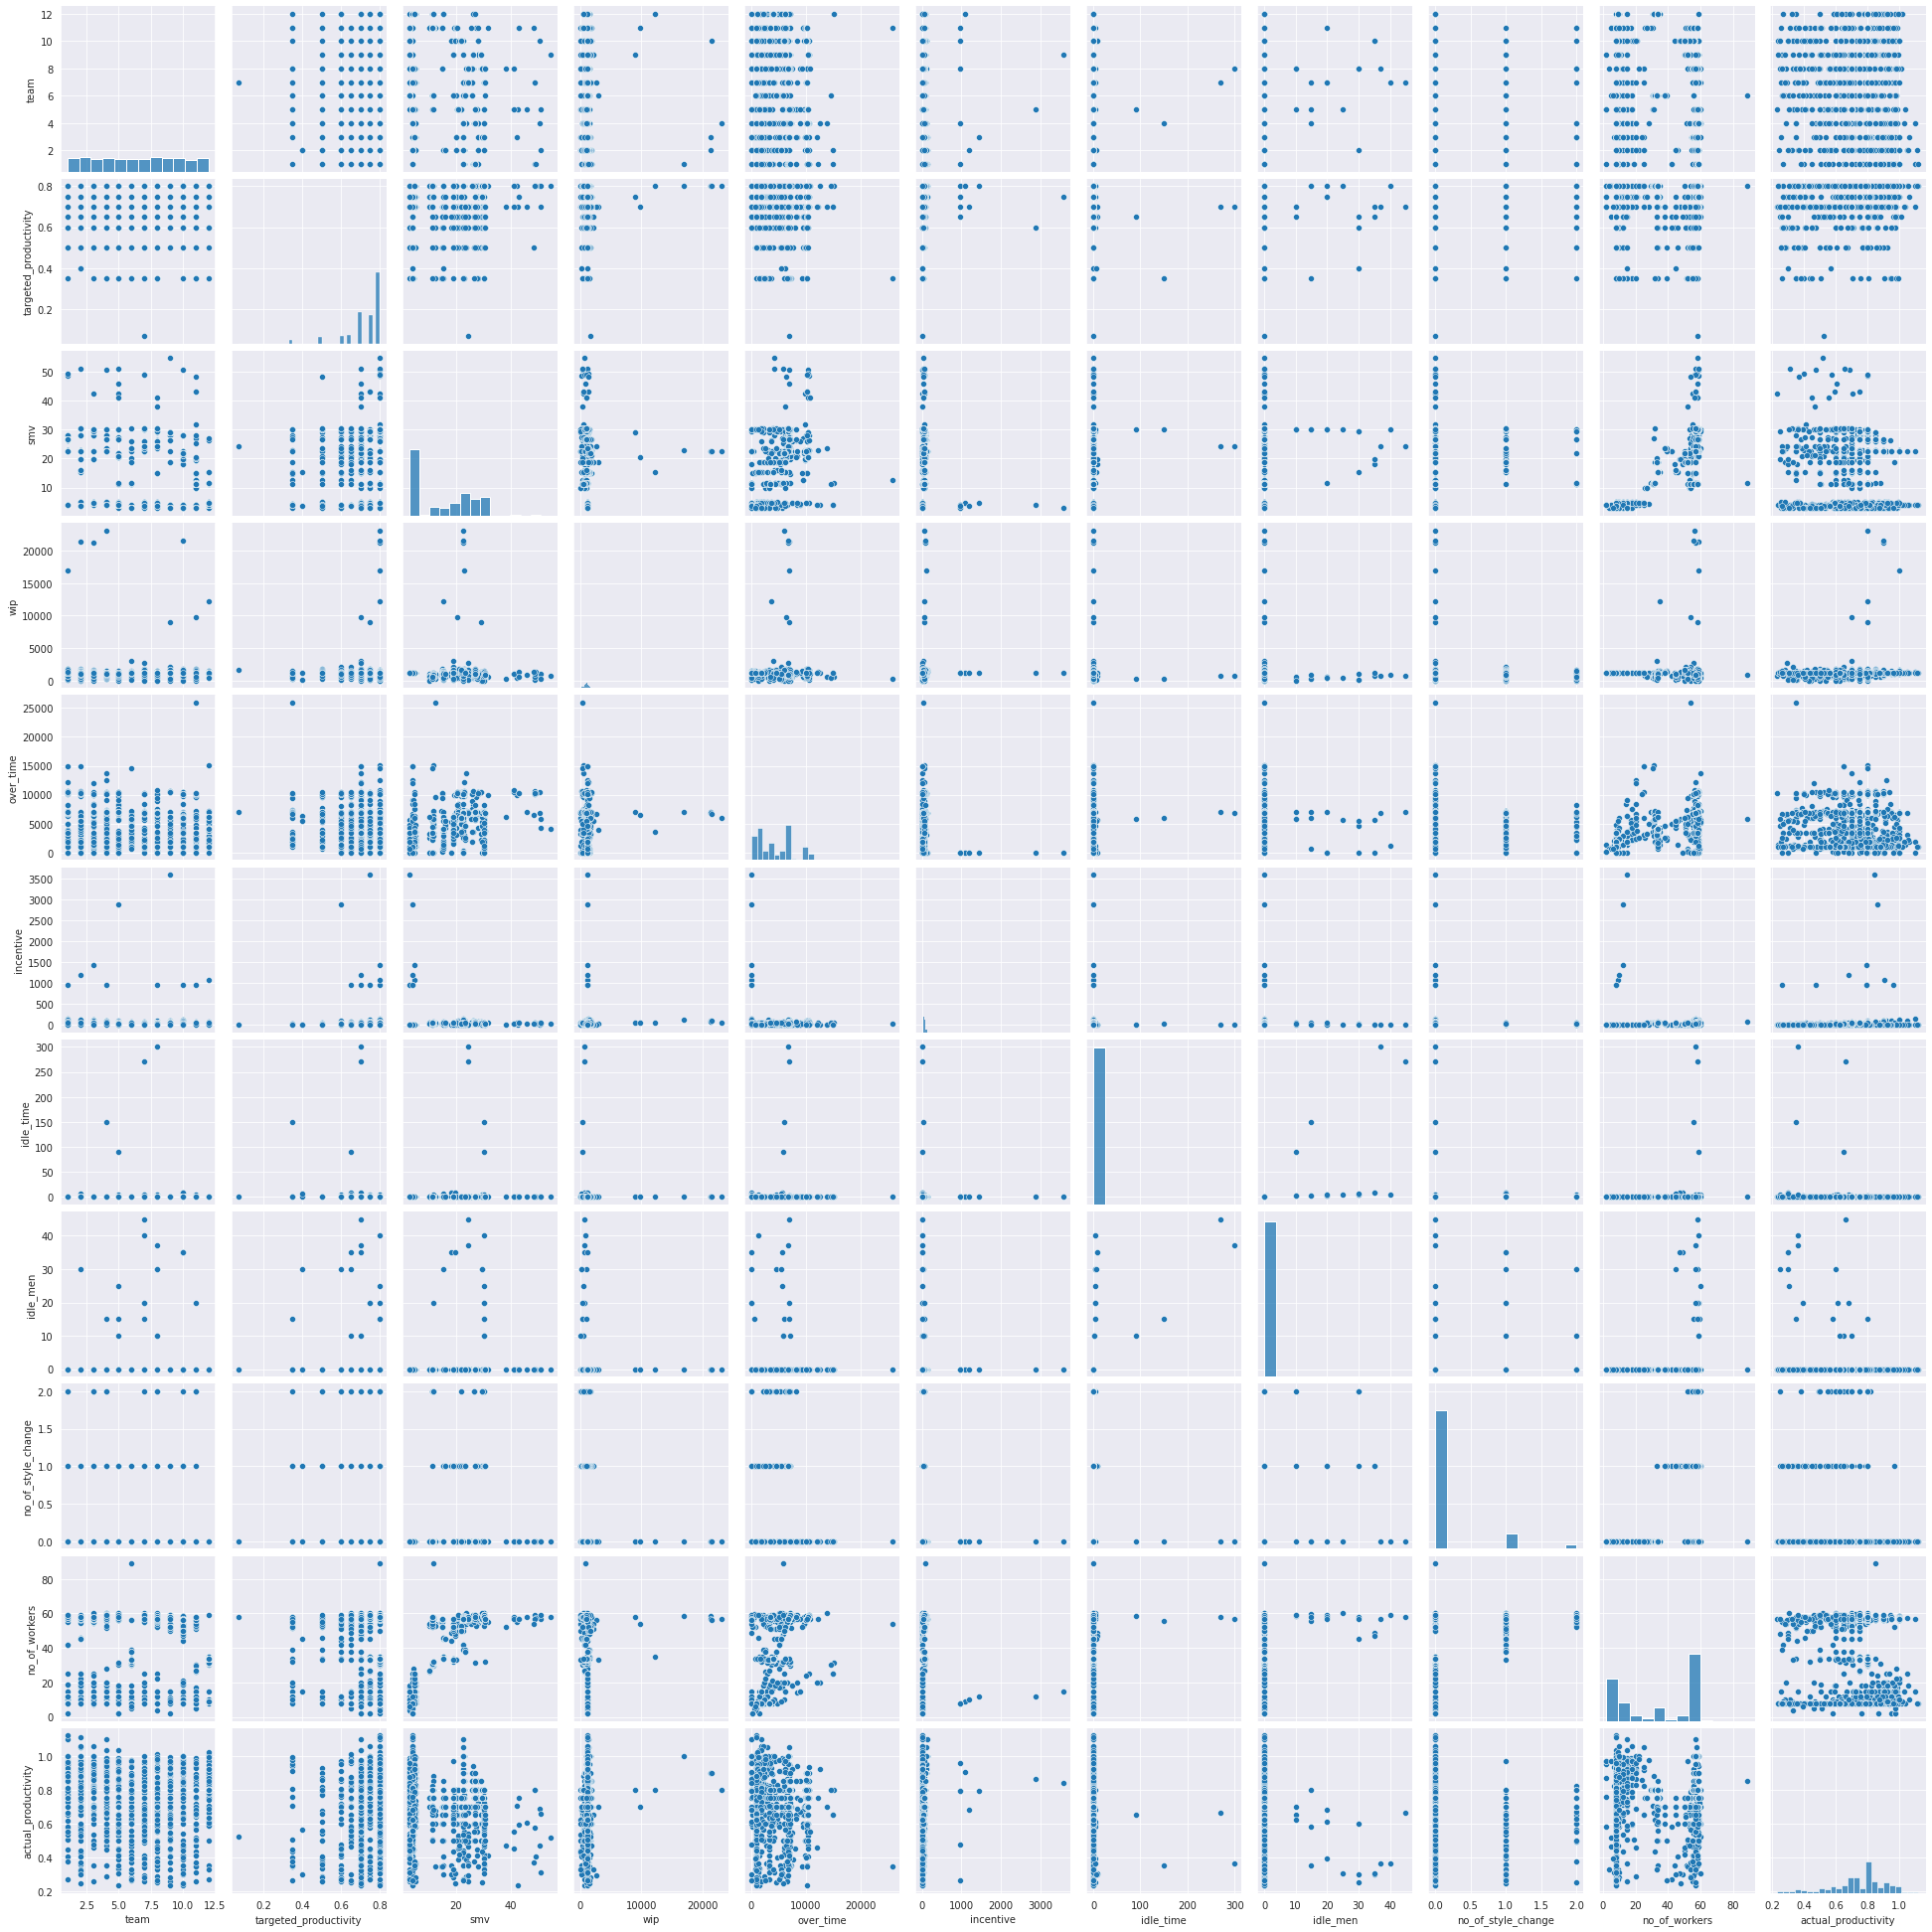

In [14]:
sns.pairplot(df)

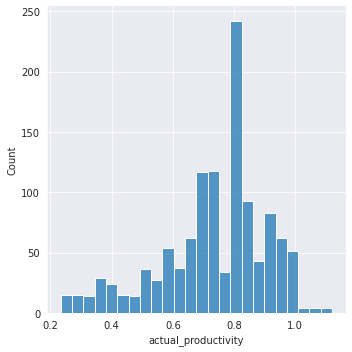

In [15]:
sns.displot(df['actual_productivity'])

<AxesSubplot:>

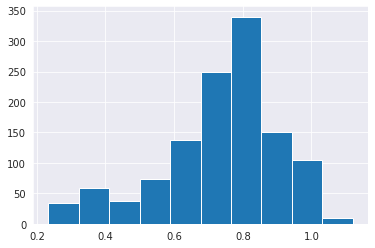

In [16]:
df.actual_productivity.hist()

<AxesSubplot:ylabel='actual_productivity'>

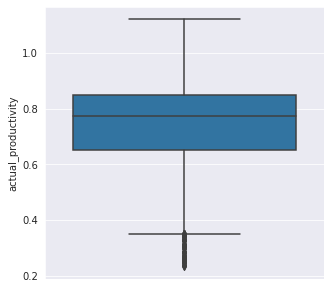

In [17]:
plt.figure(figsize=(5,5))
sns.boxplot(data=df,y='actual_productivity')

In [18]:
df.skew().sort_values(ascending=True)

targeted_productivity    -2.144150
actual_productivity      -0.807492
no_of_workers            -0.111740
team                      0.009848
smv                       0.405937
over_time                 0.673287
no_of_style_change        2.942506
idle_men                  9.855079
wip                      12.810363
incentive                15.790746
idle_time                20.545425
dtype: float64

In [19]:
from scipy.stats.mstats import normaltest
normaltest(df.actual_productivity.values)

NormaltestResult(statistic=107.39744323539699, pvalue=4.774649719927104e-24)

<AxesSubplot:>

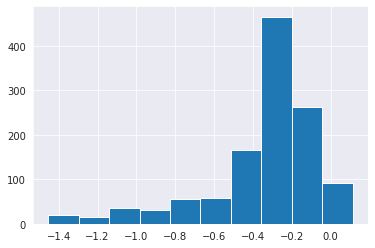

In [20]:
log_price = np.log(df.actual_productivity)
log_price.hist()

In [21]:
normaltest(log_price)

NormaltestResult(statistic=340.7761891791675, pvalue=1.00320742479004e-74)

(array([ 97.,  76., 131., 171., 365., 132., 115.,  98.,   8.,   4.]),
 array([-0.46331654, -0.40417927, -0.34504199, -0.28590472, -0.22676745,
        -0.16763018, -0.10849291, -0.04935564,  0.00978163,  0.0689189 ,
         0.12805617]),
 <BarContainer object of 10 artists>)

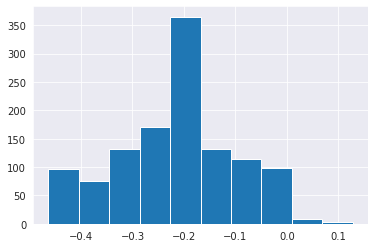

In [22]:
from scipy.stats import boxcox
bc_price= boxcox(df.actual_productivity)
boxcox_price = bc_price[0]
lambd = bc_price[1]
plt.hist(boxcox_price)  

In [23]:
normaltest(boxcox_price)

NormaltestResult(statistic=12.240154206943389, pvalue=0.0021982864609900953)

<AxesSubplot:>

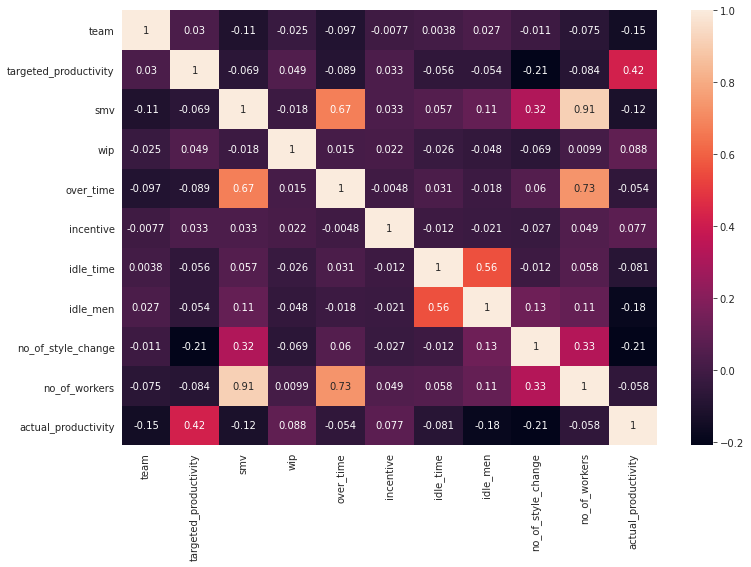

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True)

In [25]:
data=df.copy()

# Multiple linear Regression

In [26]:
le = LabelEncoder()
data['department'] = le.fit_transform(data['department'])


X=data[['targeted_productivity', 'team','smv','idle_men', 'no_of_style_change']]
y=data['actual_productivity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


s = StandardScaler()
X_train_sm = s.fit_transform(X_train)

mlr = LinearRegression()
mlr.fit(X_train_sm, y_train)
X_test_sm = s.transform(X_test)
y_pred_sm = mlr.predict(X_test_sm)

In [27]:
#Accuracy and MSE
print(f'R2 score is {r2_score(y_pred_sm,y_test)}')
print("Residual sum of squares (MSE): %.2f" % np.mean((y_pred_sm - y_test) ** 2))

R2 score is -2.4045474314511477
Residual sum of squares (MSE): 0.02


In [28]:
print(f'Co-efficients are {mlr.coef_}')
print(f'Intercept is {mlr.intercept_}')

Co-efficients are [ 0.0705507  -0.03090288 -0.01399105 -0.02763367 -0.01446043]
Intercept is 0.7342287210525688
